In [10]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal


# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(torch.cuda.is_available())
device = torch.device("cuda")

# Close all open plots
plt.close('all')

In [11]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [12]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
nExp = yExp.size


In [13]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 5)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 4

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [14]:
#Set dimensions for RNN layers
idd = dExp[0, 0].shape[1]
hdd = 15 #7 /10
ldd = 3 #2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
LTS = LSTModel(idd, hdd, ldd, odd)

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 1000

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [15]:
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yLTS = LTS(u)
    yLTS = torch.squeeze(yLTS)
    

    # Calculate loss and backpropagate
    loss = MSE(yLTS, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

Epoch: 1 	||	 Loss: 0.4738232493400574
Epoch: 2 	||	 Loss: 0.37617814540863037
Epoch: 3 	||	 Loss: 0.2819434106349945
Epoch: 4 	||	 Loss: 0.19337119162082672
Epoch: 5 	||	 Loss: 0.1337561160326004
Epoch: 6 	||	 Loss: 0.09370892494916916
Epoch: 7 	||	 Loss: 0.05592799186706543
Epoch: 8 	||	 Loss: 0.02484802156686783
Epoch: 9 	||	 Loss: 0.009567874483764172
Epoch: 10 	||	 Loss: 0.011516411788761616
Epoch: 11 	||	 Loss: 0.021306823939085007
Epoch: 12 	||	 Loss: 0.028284357860684395
Epoch: 13 	||	 Loss: 0.028598956763744354
Epoch: 14 	||	 Loss: 0.02385132387280464
Epoch: 15 	||	 Loss: 0.017195062711834908
Epoch: 16 	||	 Loss: 0.011126828379929066
Epoch: 17 	||	 Loss: 0.006988875567913055
Epoch: 18 	||	 Loss: 0.005172990262508392
Epoch: 19 	||	 Loss: 0.005409840028733015
Epoch: 20 	||	 Loss: 0.006873787846416235
Epoch: 21 	||	 Loss: 0.008483006618916988
Epoch: 22 	||	 Loss: 0.009464561007916927
Epoch: 23 	||	 Loss: 0.009569735266268253
Epoch: 24 	||	 Loss: 0.008963467553257942
Epoch: 25 	||

In [16]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 5)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yLTS_val = LTS(uval)
#yLTS_val = yLTS_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yLTS_val, yval)

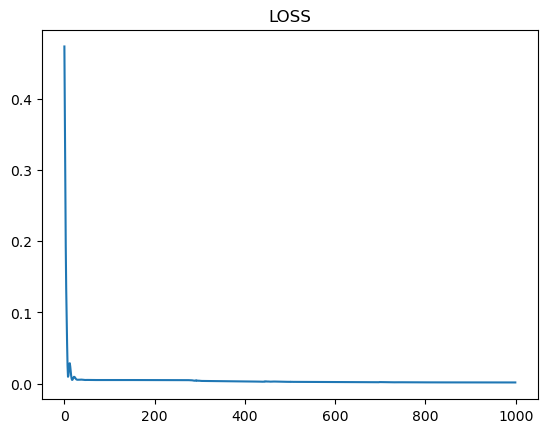

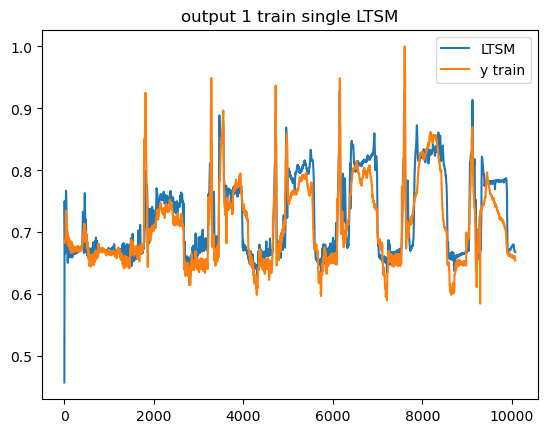

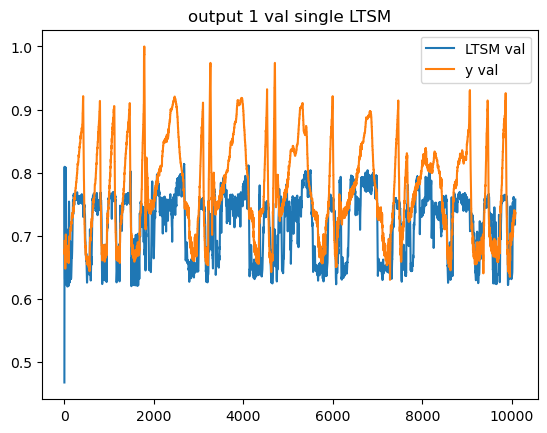

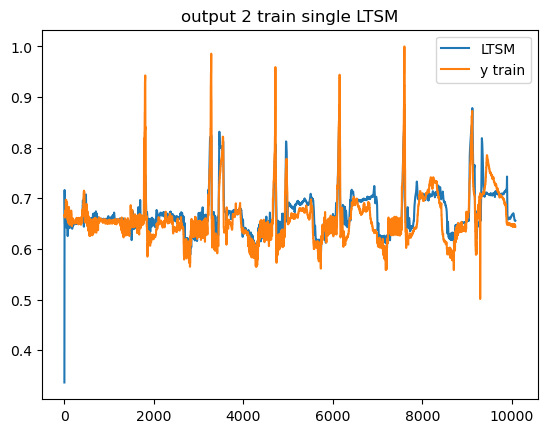

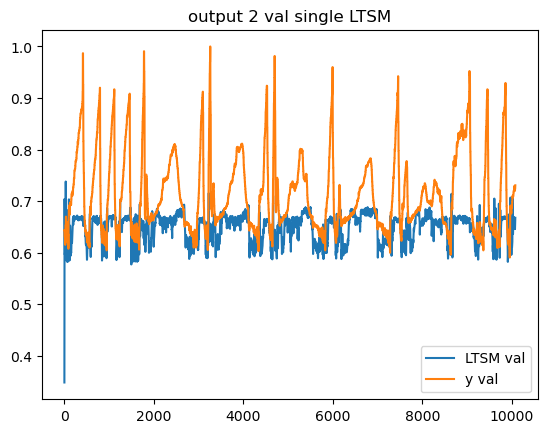

Loss Validation single LTSM: 0.007364080753177404


In [17]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yLTS[0, :, 0].detach().numpy(), label='LTSM')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single LTSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yLTS_val[0, :, 0].detach().numpy(), label='LTSM val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single LTSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yLTS[0, :, 1].detach().numpy(), label='LTSM')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single LTSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yLTS_val[0, :, 1].detach().numpy(), label='LTSM val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single LTSM")
plt.legend()
plt.show()

# Save RNN output and validation data to file
scipy.io.savemat('data_singleRNN_sysID_LTSM.mat', dict(yLTSm_val=yLTS_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single LTSM: {loss_val}")